In [1]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

Cloning into 'ML4CV_XAI'...
remote: Enumerating objects: 803, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 803 (delta 0), reused 7 (delta 0), pack-reused 789 (from 1)
Receiving objects: 100% (803/803), 63.54 MiB | 39.20 MiB/s, done.
Resolving deltas: 100% (353/353), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.5 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 13.4 MB/s eta 0:00:00
  Created wheel for grad_cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=45ff896090d7259cd48a9f2c6f533badee2399779a17a4e1f1792d2b5d1f56ec
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully 

In [1]:
%load_ext autoreload

%autoreload 2

from models import vgg11_Syntetic, vgg_preprocess
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_Syntetic().to(device)
model.load_state_dict(torch.load("VGG11_Synthetic.pt", map_location=device))
preprocess = vgg_preprocess

In [3]:
from data import SynteticFigures, BlurImagePerlinNoise, Binarize
from torchvision.transforms import InterpolationMode
from models import vgg_preprocess

TRAIN_SIZE = 8
TEST_SIZE = 128
BATCH_SIZE = 1



background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.15, saturation=0.15, hue=0.15),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomResizedCrop(224),        # Random crop + resize
    transforms.RandomHorizontalFlip(),        # Random flip
    transforms.ColorJitter(0.3, 0.3, 0.3),    # Color variations
    transforms.RandomRotation(15),            # Slight rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_train = SynteticFigures(background_path="./data/WaldoNoise",
                            num_images=TRAIN_SIZE,
                            split='train',
                            num_shapes_per_image=1,
                            image_transform=train_transform,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

data_test = SynteticFigures(background_path="./data/WaldoNoise",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=1,
                            image_transform=vgg_preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))


train_dl = DataLoader(data_train, BATCH_SIZE, shuffle=True)
test_dl = DataLoader(data_test, BATCH_SIZE, shuffle=False)

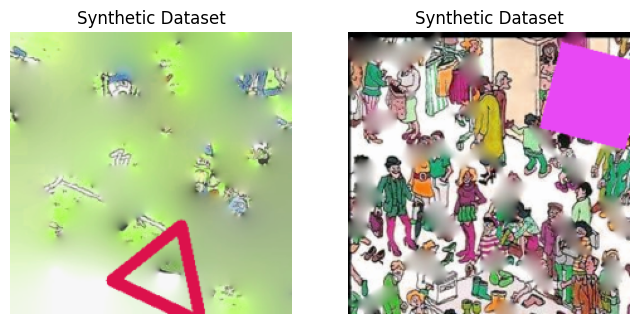

In [12]:
plt.figure(figsize=(8, 4))
for j, index in enumerate([53, 7]):
    plt.subplot(1, 2, j + 1)
    plt.title(f"Synthetic Dataset")
    img, mask, label = data_test[index]

    # De-normalize the image
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    img = img * 255
    img = img.astype(np.uint8)
    
    plt.imshow(img)
    plt.axis("off")
    # img = np.transpose(img, (2, 0, 1))

plt.savefig("./output/synthetic.pdf", dpi=300, bbox_inches='tight')

In [ ]:
from metrics import calculate_metrics, ROC_AUC, RoadCombined, Sensitivity
from results import ResultMetrics
from utils import ERFUpsamplingFast, _GradCAMPlusPlus, _DeepLiftShap, ERFUpsampling, SimpleUpsampling
from tqdm.auto import tqdm

results = ResultMetrics("./results.csv")

for layer in tqdm(model.features[10:]):
    # for attribution in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
    for attribution in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
        # for upsample in [ERFUpsamplingFast(model, layer, device), ERFUpsampling(model, layer, device), SimpleUpsampling((224,224)) ]:   
        for upsample in [ERFUpsamplingFast(model, layer, device), SimpleUpsampling((224,224))]:   
            calculate_metrics(model=model,
                            attribute_method=attribution,
                            test_dl=test_dl,
                            train_dl=train_dl,
                            layers=[layer],
                            metrics=[ROC_AUC(), RoadCombined()],
                            result_metrics=results,
                            upsample=upsample,
                            device=device,
                            model_name="VGG11",
                            contains_mask=True)
        

Results loaded from ./results.csv.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
print("zao")

zao
